## Inverse Problem - Supervised Model

Habiendo encontrado la dimensión mínima necesaria -para reconstruir las firmas polarimétricas- del espacio latente, nos disponemos a resolver el problema inverso utilizando los variables del espacio latente como predictoras.

La idea es generar firmas etiquetadas variando un solo parámetro físico -por ejemplo la constante dieléctrica-, "pasarlas" por un encoder previamente entrenado para generar variables predictivas. Luego utilizar dichas variables, junto con su etiqueta para entrenar un modelo supervisado y así poder predecir variables biofísicas a partir de firmas polarimétricas.

In [1]:
import json
import os
import pickle as pkl

import numpy as np
import pandas as pd
import tqdm 
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt

from src.data.create_data import make_labeled_data ,save_data, load_data
from src.models.saving import load_model, load_configuration
from src.models.model_wrappers import build_cae_architecture
from src.features.preprocess_data import RScaler_beta, to_dB, remove_outliers
from src.visualization.visualize import (plot_polarization_signature,
                                                            plot_histogram)

2023-01-23 09:48:38.795608: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:
2023-01-23 09:48:38.796065: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:
2023-01-23 09:48:38.796073: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


### 1. Firmas etiquetadas y preprocesamiento

Genero datos sampleando la constante dieléctrica de la $1^{er}$ superficie de una distribución plana en el intervalo $(3, 38]$.

In [2]:
# Numero de experimentos e intervalo de sampleo
realizations = 20000
variables = {"epsilon" : (3, 35)}

#Genero y guardo los datos
X_raw, y_raw = make_labeled_data(realizations, variables=variables)

src_dir = os.path.normpath(os.getcwd() + "/..")
data_dir = os.path.join(src_dir, "data/spm/raw")
file_path = os.path.join(data_dir, "spm_labeled_signatures.pkl")

with open(file_path, "wb") as file_:
   pkl.dump((X_raw, y_raw), file_)    

Procesamos las firmas para poder introducirlas en el modelo no supervisado y generar las variables predictoras (outputs de las unidadesd el espacio latente de CAE). Comenzamos removiendo outliers y pasando los datos a dB:

In [2]:
src_dir = os.path.normpath(os.getcwd() + "/..")
data_dir = os.path.join(src_dir, "data/spm/raw")
file_path = os.path.join(data_dir, "spm_labeled_signatures.pkl")

with open(file_path, "rb") as file_:
   X_raw, y_raw = pkl.load(file_) 

In [4]:
print(f"Valor máximo de potencia: {X_raw.max()}")
print(f"Valor mínimo de potencia: {X_raw.min()}")

Valor máximo de potencia: 0.013199431507492034
Valor mínimo de potencia: -0.026230334323093147


In [6]:
X, y = remove_outliers(X_raw, labels=y_raw, k=100)
X_dB = to_dB(X)
print(f"Muestras luego de remover outliers: {X_dB.shape[0]}")
print(f"Valor máximo de potencia: {X_dB.max()}")
print(f"Valor mínimo de potencia: {X_dB.min()}")

Muestras luego de remover outliers: 12071
Valor máximo de potencia: -19.9779067462895
Valor mínimo de potencia: -106.70514199855225


<AxesSubplot:title={'center':'Polarization Signature values distribution'}, xlabel='$\\sigma(\\psi, \\chi)$', ylabel='Count'>

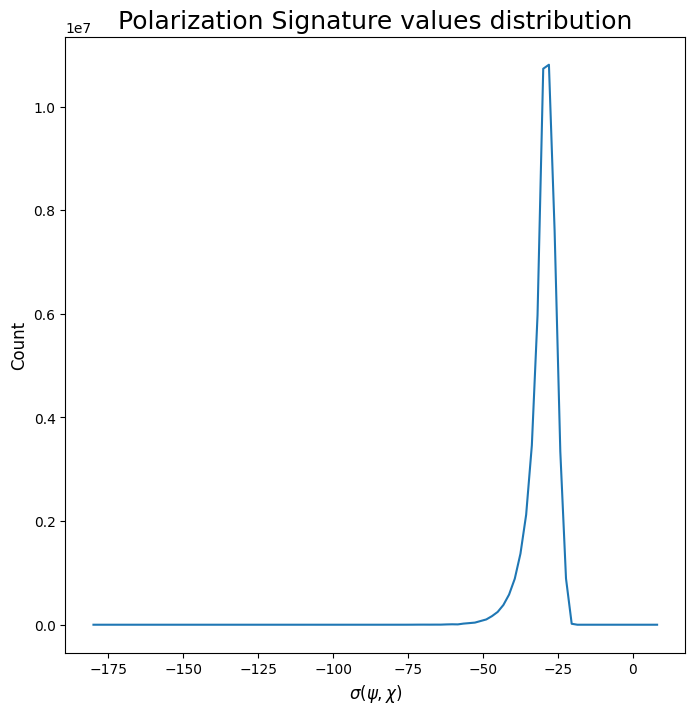

In [7]:
plot_histogram(X_dB, hist_kw={"range":(-180, 10)})

Separamos en conjuntos de entrenamiento y testeo, y normalizamos.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X_dB, 
    y, 
    random_state=123, 
    test_size=.2
    )

print(f"Tamaño de los datos de entrenamiento: {X_train.shape=} {y_train.shape=}")
print(f"Tamaño de los datos de testeo: {X_test.shape=} {y_test.shape=}")

Tamaño de los datos de entrenamiento: X_train.shape=(9656, 45, 90) y_train.shape=(9656, 1)
Tamaño de los datos de testeo: X_test.shape=(2415, 45, 90) y_test.shape=(2415, 1)


In [9]:
scaler = RScaler_beta().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Conjunto de entrenamiento: mean={np.mean(X_train_scaled)}, dev={np.std(X_train_scaled)}")
print(f"Conjunto de testeo: mean={np.mean(X_test_scaled)}, dev={np.std(X_test_scaled)}")

Conjunto de entrenamiento: mean=-0.16788515835637505, dev=0.9768915369006346
Conjunto de testeo: mean=-0.15385290576243318, dev=0.9799399980890412


Tomemos algún ejemplo al azar del conjunto de entrenamiento y visualicémoslo

Text(0.5, 1.0, '$\\sigma(\\psi, \\chi)$ --- $\\epsilon$ = 28.498')

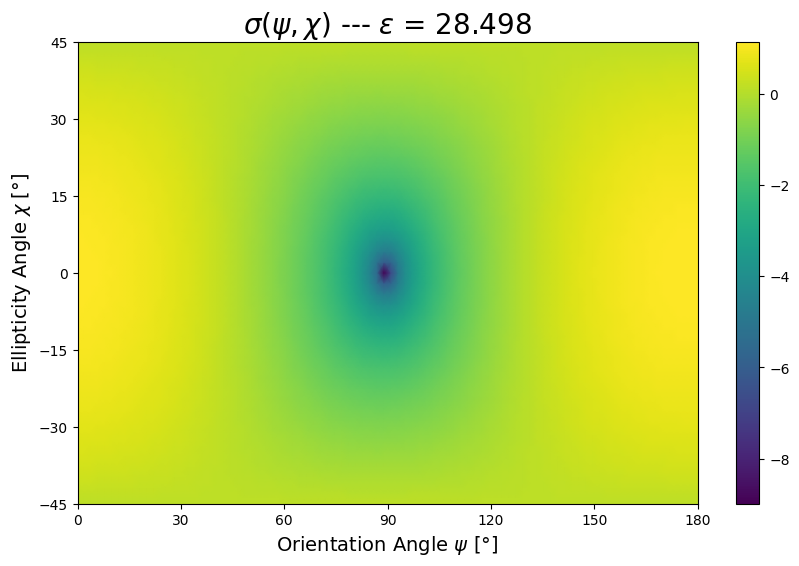

In [10]:
# Elegimos ana firma al azar
rng = np.random.default_rng()
rnd_index = rng.integers(X_train_scaled.shape[0])
rnd_signature = X_train_scaled[rnd_index, :, :]

# Ploteamos
ax = plt.gca()
plot_polarization_signature(rnd_signature, ax=ax)
ax.set_title(f"$\sigma(\psi, \chi)$ --- $\epsilon$ = {y_train[rnd_index, 0]:.3f}", fontsize = 20)

Veamos un histograma de los conjuntos de entrenamiento y testeo

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

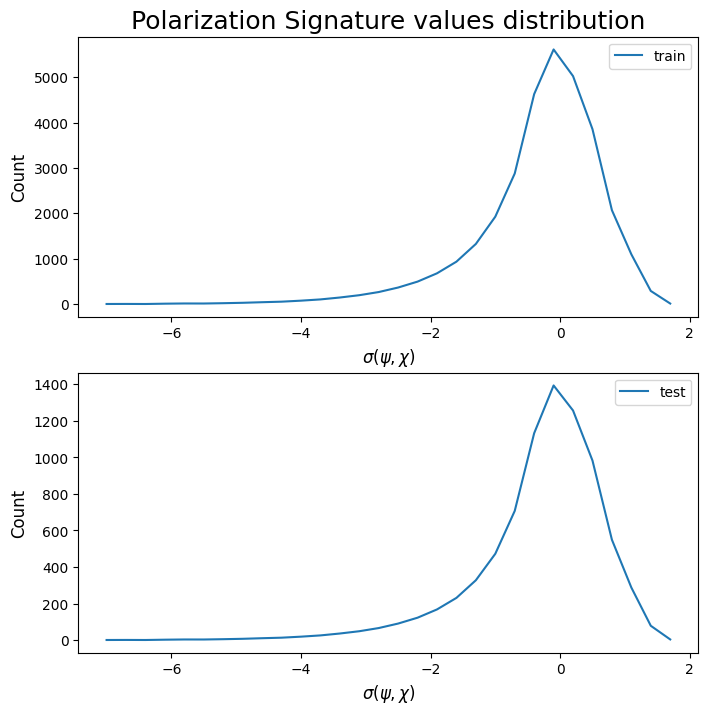

In [11]:
# Rango de valores válidos para los histogramas
train_range = np.min(X_train_scaled), np.max(X_train_scaled) 
test_range = np.min(X_test_scaled), np.max(X_test_scaled)

fig, ax1 = plt.subplots(2, 1, figsize=(20, 10))
plot_histogram(
    X_train_scaled, 
    ax=ax1[0], 
    n_bins=30,
    hist_kw={'range' : (-7, 2), 'density' : True}, 
    plot_kw={'label' : 'train'}
    )
plot_histogram(
    X_test_scaled, 
    ax=ax1[1],
    n_bins=30, 
    hist_kw={'range' : (-7, 2), 'density' : True}, 
    plot_kw={'label' : 'test'}
    )

ax1[1].set_title('')
for ax in ax1:
    ax.legend()

plt.tight_layout   

In [12]:
X_train_scaled = np.expand_dims(X_train_scaled, axis=-1) 
X_test_scaled = np.expand_dims(X_test_scaled, axis=-1)

print(f'Tamaño de los datos de entrenamiento: {X_train_scaled.shape}')
print(f'Tamaño de los datos de testeo: {X_test_scaled.shape}')

Tamaño de los datos de entrenamiento: (9656, 45, 90, 1)
Tamaño de los datos de testeo: (2415, 45, 90, 1)


### 2.0 Variables del Latent Space

Pasamos los datos preprocesados por el modelo obtenido en 5.0, con el número mínimo de unidades en el espacio latente que reconstruyen las firmas. Para ello cargamos el modelo entrenado y lo usamos para transformar nuestro dataset.

In [13]:
cae_configuration = load_configuration("model_architecture")
config_keys = ('conv_layers_config', 'dense_layers_config')

configuration = {keys : cae_configuration[keys] for keys in config_keys}
configuration.update({"latent_dimension" : 2})

print(configuration)

{'conv_layers_config': {'layers_config': [[4, [3, 4], 2], [4, [3, 3], 1]], 'kernel_initializer': 'glorot_uniform'}, 'dense_layers_config': {'layers_units': [256]}, 'latent_dimension': 2}


In [14]:
model, configuration = load_model(name="final_cae")

# Transform signatures into latent space variables
ls_variables_train = model.encoder(X_train_scaled)
ls_variables_test = model.encoder(X_test_scaled)

### 3.0 entrenamos un RandomForest

Vamos a utilizar las variables transformadas para entrenar un Random Forest sin optimizar y ver que tan predictivas son nuestras variables

In [15]:
rf_model = RandomForestRegressor(random_state=123)
rf_model.fit(ls_variables_train.numpy(), y_train.ravel())

y_predict = rf_model.predict(ls_variables_test.numpy())
mse = mean_squared_error(y_test, y_predict)

In [16]:
print(rf_model.score(ls_variables_test, y_test.ravel()))
print(rf_model.feature_importances_)

0.9964371587958875
[0.8693437 0.1306563]


Probamos el mismo modelo, pero alimentado directamente con las firmas polarimétricas. Para eso las concatenamos en un vector, calculamos las componentes principales y solo nos quedamos con las que expliquen una cantidad significativa de varianza.

In [17]:
# Desenrollo las imagenes
n_samples_train = X_train_scaled.shape[0]
n_samples_test = X_test_scaled.shape[0]

X_train_unroll = X_train_scaled.reshape((n_samples_train, -1))
X_test_unroll = X_test_scaled.reshape((n_samples_test, -1))

print(f"Tamaño de los datos de entrenamiento: {X_train_unroll.shape}")
print(f"Tamaño de los datos de testeo: {X_test_unroll.shape}")

Tamaño de los datos de entrenamiento: (9656, 4050)
Tamaño de los datos de testeo: (2415, 4050)


<AxesSubplot:title={'center':'$\\sigma(\\psi,\\chi)$'}, xlabel='Orientation Angle $\\psi$ [°]', ylabel='Ellipticity Angle $\\chi$ [°]'>

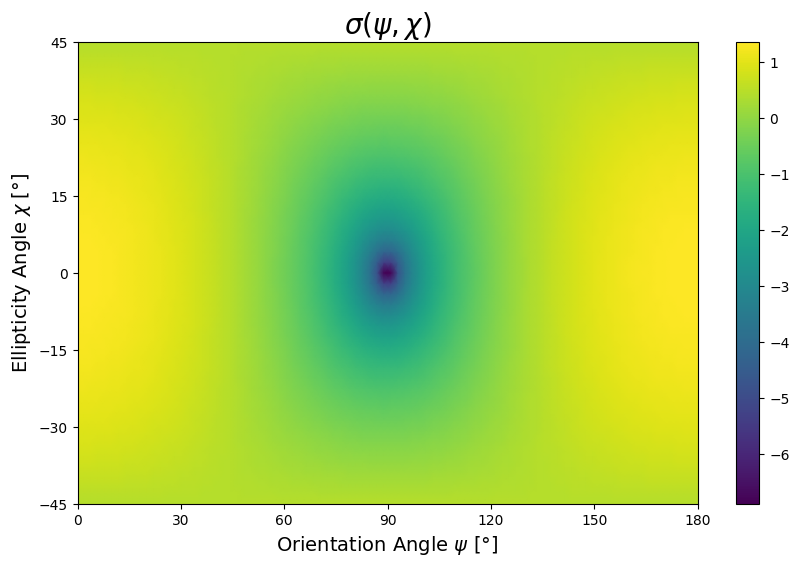

In [18]:
pca = PCA(n_components=100)

X_train_pca = pca.fit_transform(X_train_unroll)
X_test_pca = pca.transform(X_test_unroll)

# Elijo una muestra al azar y la visualizo
rng = np.random.default_rng()
idx = rng.integers(X_train_pca.shape[0])

reconstructed_img = pca.inverse_transform(X_train_pca)
plot_polarization_signature(reconstructed_img[idx, :].reshape((45, 90)))

Text(0, 0.5, 'Fracción de varianza acumulada')

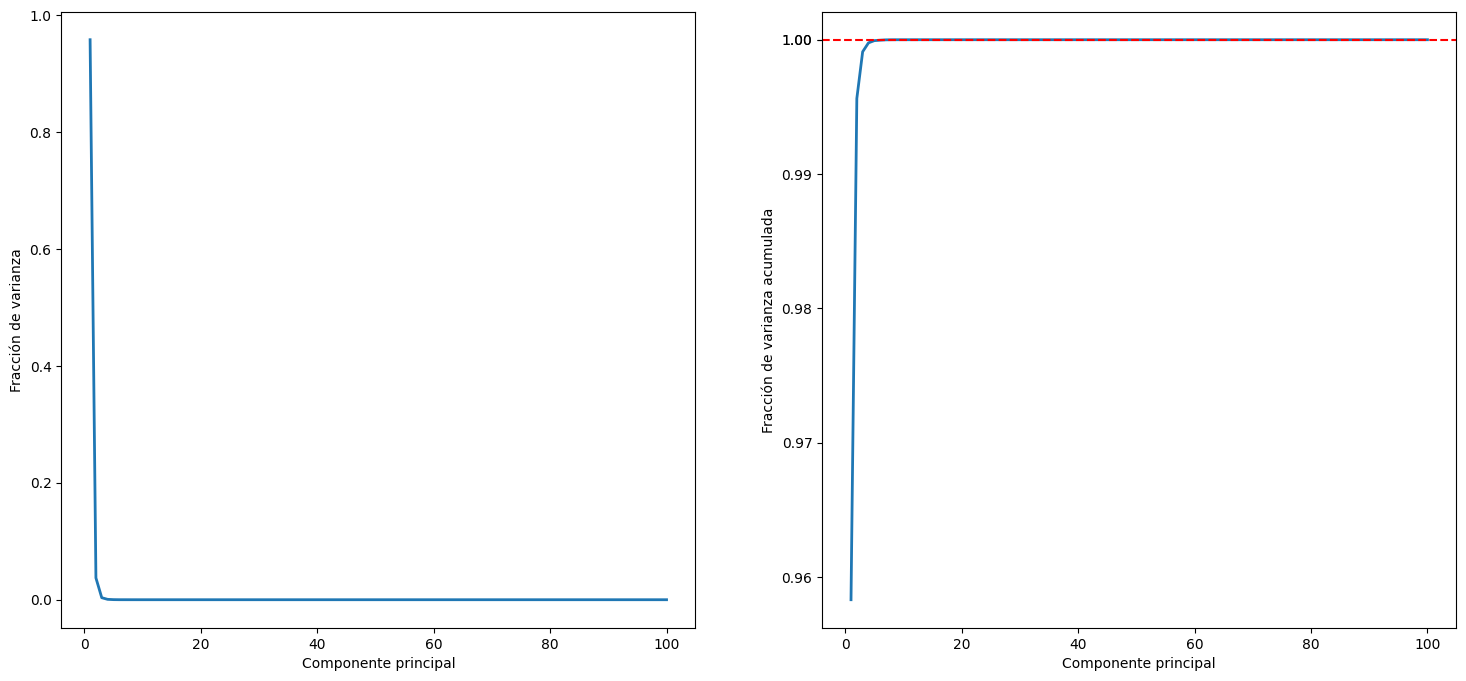

In [19]:
# Extraemos la varianza explicada de cada componente
variance_ratio = pca.explained_variance_ratio_

# Ploteamos la variancia y la suma acumulada
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

ax[0].plot(range(1, 101), variance_ratio,
           linewidth=2)
ax[0].set_xlabel('Componente principal')
ax[0].set_ylabel('Fracción de varianza')

ax[1].plot(range(1, 101), np.cumsum(variance_ratio),
           linewidth=2)
ax[1].axhline(y=np.cumsum(variance_ratio)[-50], 
              color='r', linestyle='--')
lim = ax[1].get_ylim()
ax[1].set_yticks(list(ax[1].get_yticks()) + [np.cumsum(variance_ratio)[-50]])
ax[1].set_ylim(lim)
ax[1].set_xlabel('Componente principal')
ax[1].set_ylabel('Fracción de varianza acumulada')

En el gráfico anterior podemos ver que las primeras --- componentes explican el --- de la varianza total. Podemos reducir sin perder mucha información.

Ahora entrenemos el mismo modelo Rando Forest utilizando estos datos y veamos si existe una mejora en traducir los datos a las variables del espacio latente

In [20]:
rf_model_pca = RandomForestRegressor(random_state=123)
rf_model_pca.fit(X_train_pca, y_train.reshape((n_samples_train,)))

score = rf_model_pca.score(X_test_pca, y_test.reshape((n_samples_test,)))
print(score)

0.999982796416016


El modelo entrenado con variables del espacio latente no parece tener mejor performance que entrenar directamente con las firmas. Veamos qué pasa cuando pedimos que nos prediga más de una variable: arranquemos con $\epsilon$ y $s_{rms}$ de la capa superior. Después podemos agregar la constante dieléctrica de la capa inferior también.

### 4.0 Retrieval de dos variables o más

Generamos los datos y los preprocesamos igual que antes: removemos outliers, pasamos a dB, separamos en train set y test set y escaleamos.

In [21]:
vars = {
    "epsilon" : (3, 35),
    "rms_high" : (0.004, 0.012)
}

X_raw, y_raw = make_labeled_data(realizations, variables=vars)

file_path = os.path.join(data_dir, "spm_labeled_signatures_vars.pkl")

with open(file_path, "wb") as file_:
  pkl.dump((X_raw, y_raw), file_)  

In [22]:
with open(file_path, "rb") as file_:
   X_raw, y_raw = pkl.load(file_)

In [24]:
X, y = remove_outliers(X_raw, labels=y_raw, k=100)
X_dB = to_dB(X)
X_train, X_test, y_train, y_test = train_test_split(
    X_dB, 
    y,
    random_state=123, 
    test_size=.2
    )   

In [25]:
scaler = RScaler_beta().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = np.expand_dims(X_train_scaled, axis=-1) 
X_test_scaled = np.expand_dims(X_test_scaled, axis=-1)

print(f'Tamaño de los datos de entrenamiento: {X_train_scaled.shape}')
print(f'Tamaño de los datos de testeo: {X_test_scaled.shape}')


Tamaño de los datos de entrenamiento: (7822, 45, 90, 1)
Tamaño de los datos de testeo: (1956, 45, 90, 1)


Finalmente transformamos de firmas polarimétricas a variables del espacio latente.

In [26]:
# Transform signatures into latent space variables
ls_variables_train = model.encoder(X_train_scaled)
ls_variables_test = model.encoder(X_test_scaled)

In [34]:
print(ls_variables_train.shape)
print(ls_variables_test.shape)

(7822, 2)
(1956, 2)


: 

Volvemos a entrenar un Random Forest con las variables del espacio latente 

In [27]:
rf_model = RandomForestRegressor(random_state=123)
rf_model.fit(ls_variables_train.numpy(), y_train)

y_predict = rf_model.predict(ls_variables_test.numpy())
mse = mean_squared_error(y_test, y_predict)

In [28]:
print(rf_model.score(ls_variables_test, y_test))

0.8169657557383212


Ahora comparamos con el modelo que surge de en entrenar con firmas directamente

In [29]:
# Desenrollo las imagenes
n_samples_train = X_train_scaled.shape[0]
n_samples_test = X_test_scaled.shape[0]

X_train_unroll = X_train_scaled.reshape((n_samples_train, -1))
X_test_unroll = X_test_scaled.reshape((n_samples_test, -1))

print(f"Tamaño de los datos de entrenamiento: {X_train_unroll.shape}")
print(f"Tamaño de los datos de testeo: {X_test_unroll.shape}")

Tamaño de los datos de entrenamiento: (7822, 4050)
Tamaño de los datos de testeo: (1956, 4050)


<AxesSubplot:title={'center':'$\\sigma(\\psi,\\chi)$'}, xlabel='Orientation Angle $\\psi$ [°]', ylabel='Ellipticity Angle $\\chi$ [°]'>

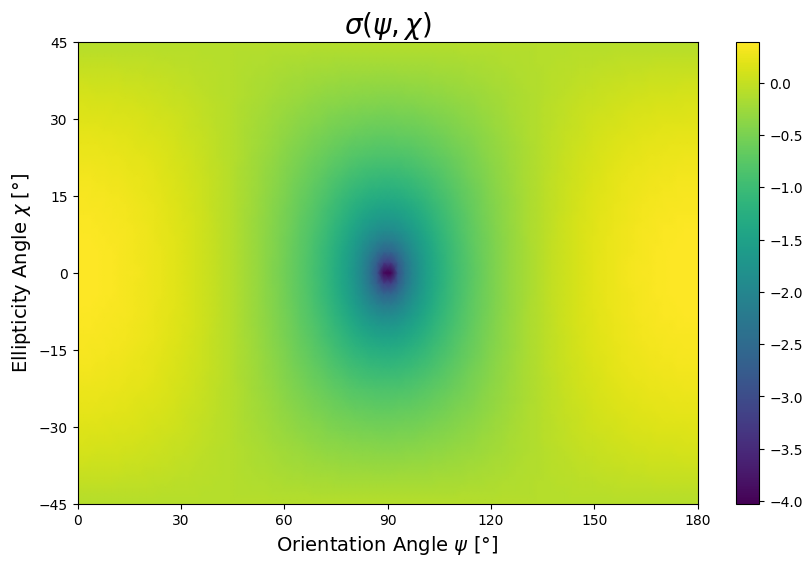

In [30]:
pca = PCA(n_components=100)

X_train_pca = pca.fit_transform(X_train_unroll)
X_test_pca = pca.transform(X_test_unroll)

# Elijo una muestra al azar y la visualizo
rng = np.random.default_rng()
idx = rng.integers(X_train_pca.shape[0])

reconstructed_img = pca.inverse_transform(X_train_pca)
plot_polarization_signature(reconstructed_img[idx, :].reshape((45, 90)))

Text(0, 0.5, 'Fracción de varianza acumulada')

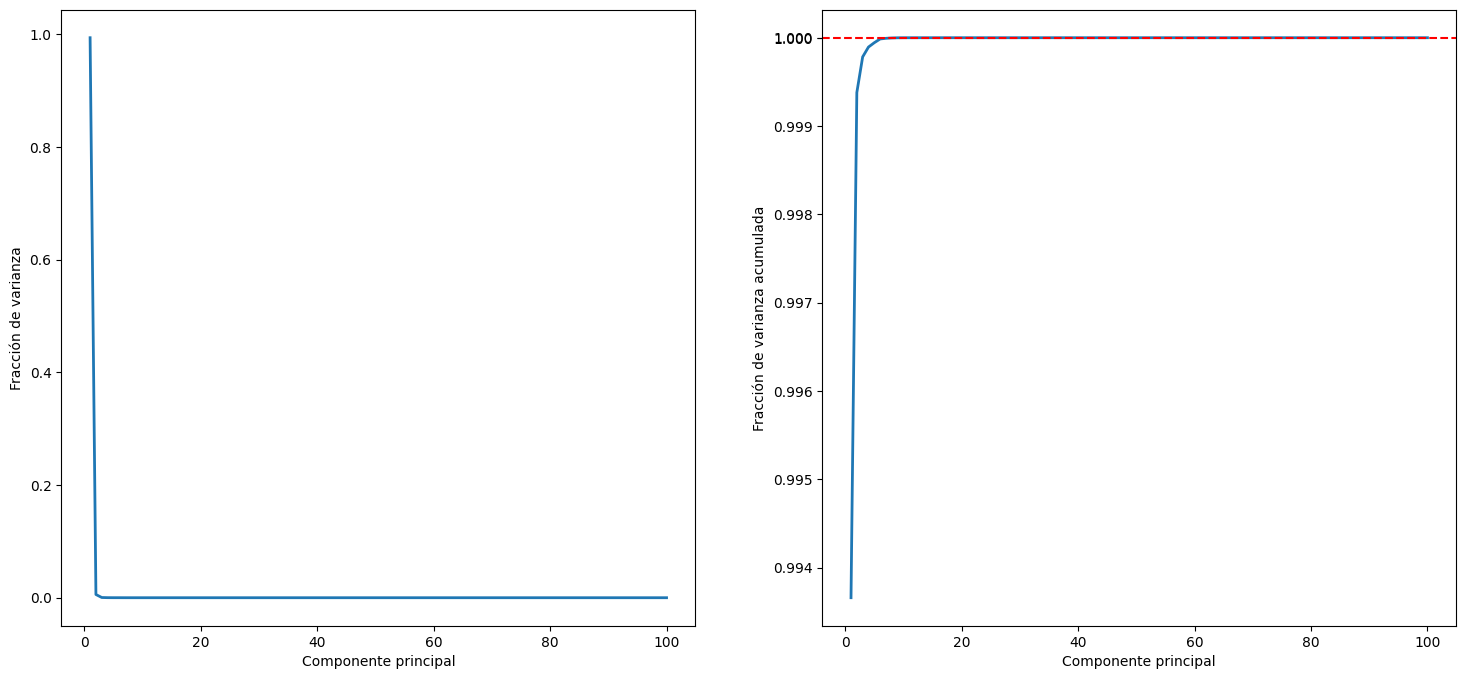

In [31]:
# Extraemos la varianza explicada de cada componente
variance_ratio = pca.explained_variance_ratio_

# Ploteamos la variancia y la suma acumulada
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

ax[0].plot(range(1, 101), variance_ratio,
           linewidth=2)
ax[0].set_xlabel('Componente principal')
ax[0].set_ylabel('Fracción de varianza')

ax[1].plot(range(1, 101), np.cumsum(variance_ratio),
           linewidth=2)
ax[1].axhline(y=np.cumsum(variance_ratio)[-50], 
              color='r', linestyle='--')
lim = ax[1].get_ylim()
ax[1].set_yticks(list(ax[1].get_yticks()) + [np.cumsum(variance_ratio)[-50]])
ax[1].set_ylim(lim)
ax[1].set_xlabel('Componente principal')
ax[1].set_ylabel('Fracción de varianza acumulada')

En el gráfico anterior podemos ver que las primeras --- componentes explican el --- de la varianza total. Podemos reducir sin perder mucha información.

Ahora entrenemos el mismo modelo Rando Forest utilizando estos datos y veamos si existe una mejora en traducir los datos a las variables del espacio latente

In [32]:
rf_model_pca = RandomForestRegressor(random_state=123)
rf_model_pca.fit(X_train_pca, y_train)

score = rf_model_pca.score(X_test_pca, y_test)
print(score)

0.9924666196268395
